## Analysis of Web Bounce Times: When _Not_ to use Mixed Models

This dataset is from kaggle and contains records of bounce time and age of website viewer grouped by county. When I initially saw this dataset it was accompanied by a notebook in which the analyst utilized a mixed effects model. However, as we shall see this approach is problematic for a number of reasons.

* [Getting Set Up and Exploring the Data](#data)
* [Visualization of Mixed Effects Models and Parameter Shrinkage](#lme)
* [Why lme() is a Bad Idea](#bad)
* [Conclusion](#fin)




<a id='data'></a> 
## Getting Set Up and Exploring the Data

This dataset is simple with only two continuous variables to deal with: bounce_time and age. There are two additional grouping factors: county and location. This analysis will focus on attempts to utilyze the county feature in a classical (hierarchical) mixed effects model. To get started we just need to istall the packages we'll use and read the csv containing the data.

In [5]:
z <-  c("lattice", "rje", "nlme", "ggplot2", "gridExtra", "readr")
lapply(z, require, character.only = TRUE)

data <- read_csv("data.csv")


Loading required package: lattice

Loading required package: rje

Loading required package: nlme

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked _by_ ‘.GlobalEnv’:

    mpg


Loading required package: gridExtra



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE


── Column specification ────────────────────────────────────────────────────────
cols(
  bounce_time = col_double(),
  age = col_double(),
  county = col_character(),
  location = col_character()
)




In [6]:
dim(data)
names(data)

[1] 480   4

[1] "bounce_time" "age"         "county"      "location"

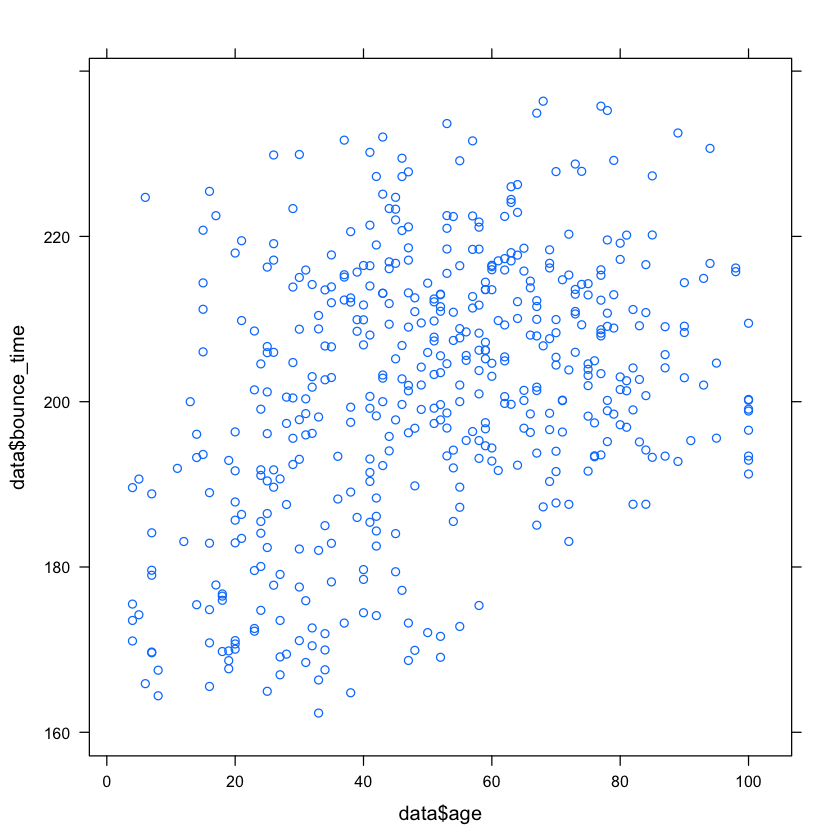

In [7]:
xyplot(data$bounce_time ~ data$age)

From the scatter plot printed above it looks like we shoul be able to fit a significant classical linear model of the form bounce_time ~ age. We can also see that it's not going to be great and we should expect a low R squared. Playing around with transforming the response or including and age^2 covariate are always options but from the scatter plot it doesn't seem like those options will be viable.

So let's just go ahead and fit a classical linear model and see what we get.


Call:
lm(formula = bounce_time ~ age, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.175 -10.635   0.661  10.569  35.659 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 187.40913    1.65921 112.951   <2e-16 ***
age           0.27553    0.02996   9.197   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.96 on 478 degrees of freedom
Multiple R-squared:  0.1503,	Adjusted R-squared:  0.1486 
F-statistic: 84.58 on 1 and 478 DF,  p-value: < 2.2e-16


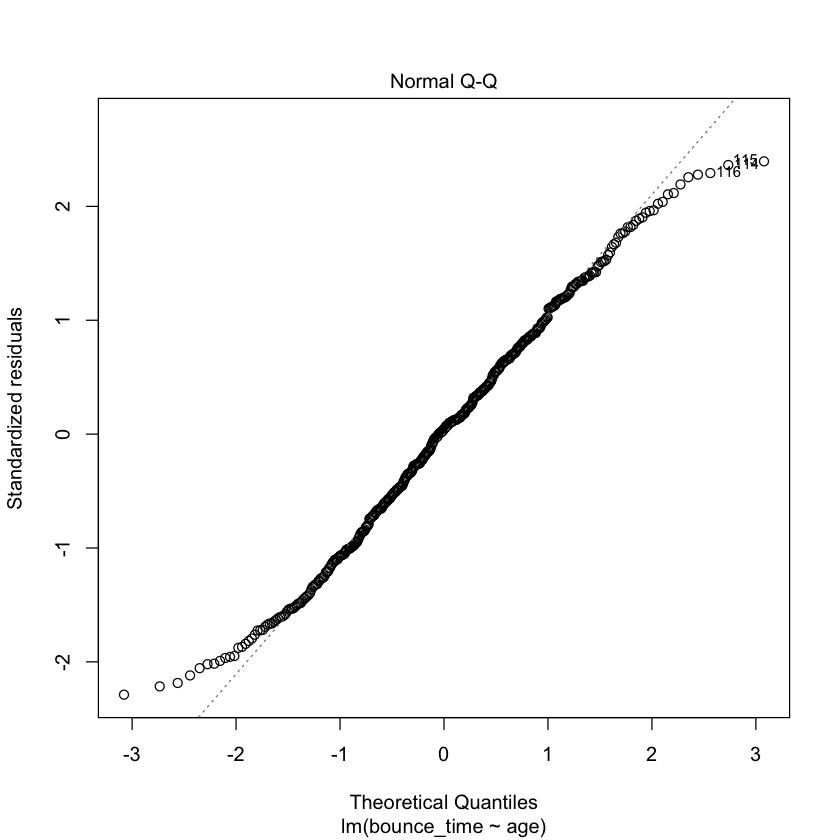

In [25]:
fitlm <- lm(bounce_time ~ age, data)
summary(fitlm)
plot(fitlm, 2)

The summary printout is as we should have expected and it looks like out residuals are not terribly normal, but rather a bit "light tailed." There's not anything we can really do to improve this classical linear model so let's go ahead (naiively) and fit a mixed effects model using a random effect of the form `random = ~age|county`.

<a id='lme'></a>
## Visualization of Mixed Effects Models and Parameter Shrinkage

In [9]:
fitlme <- lme(bounce_time ~ age, random = ~age|county, data)
sigma(fitlme)
sigma(fitlm)

[1] 8.605379

[1] 14.95953

If we couldn't be bothered with any sort of diagnostics we might convince ourselves that this mixed effect model was a considerable improvement. And, in fairness it did reduce the residual standard error, but we will soon see what makes this model problematic from an explanatory viewpoint.

Below I have some ugly R code which grabs all the parameter estimates from 1.) by group ie no pooling models fitted to each county 2.) the parameter estimates from the mixed effects model and 3.) the parameter from the classical linear model above ie the pooling model.

In [33]:
f <- function(l){
  i = 1
  v <- c()
  w <- c()
  while(i <= length(l)){
  m <- update(fitlm, subset = (county == l[i]))
  v[i] <- coef(m)[1]
  w[i] <- coef(m)[2]
  i = i + 1 
  }
  df <- data.frame("intercept" = v, "age" = w)
  rownames(df) <- l 
  df
}
l <- rownames(coef(fitlme))


df2 <- data.frame("intercept" = c( f(l)[,1], coef(fitlme)[,1], coef(fitlm)[1]), "age" = c(f(l)[,2], coef(fitlme)[,2], coef(fitlm)[2]), 
                  "county" = c(rep(rownames(f(l)), 2), 0), "type" = c(rep(3, 8), rep(2, 8), 1)  )

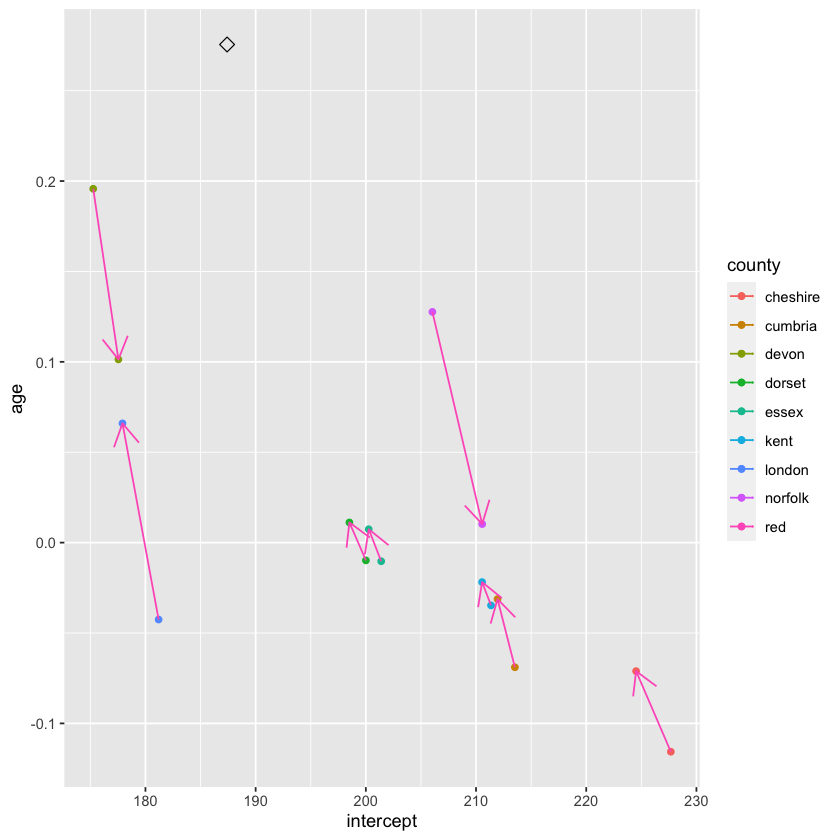

In [34]:
p <- ggplot(data = df2, aes(x = intercept, y = age)) + 
  geom_point(data = subset(df2,  type == 1), shape = 23, size = 3) +
  geom_point(data = subset(df2,  type == 2),aes(color = county)) +
  geom_point(data = subset(df2,  type == 3),aes(color = county)) +
  geom_path(aes(group = county, color = "red"),arrow = arrow(length = unit(.04, "npc")))

p


The graph above nicely demonstrates the shrinkage of parameters from the no pooling approach to the mixed effect model. However, there is something off about this graph. The diamond point in the upper left represents the parameter estimates in the pooling model. Ordinarily, you would expect the parameters to "shrink towards" that point. In this case though it looks like the slope ie age parameters are shrinking toward zero. And, there should be another thing strange about the plotted points above. The bases of the arrows represent the no pooling models and you can clearly see that _most_ of the slopes are negative, whereas the original scatter plot clearly showed a positive relationship.

If we color code the points in the original scatter plot by county we might be able to see if there is something strange about the way they're grouped.

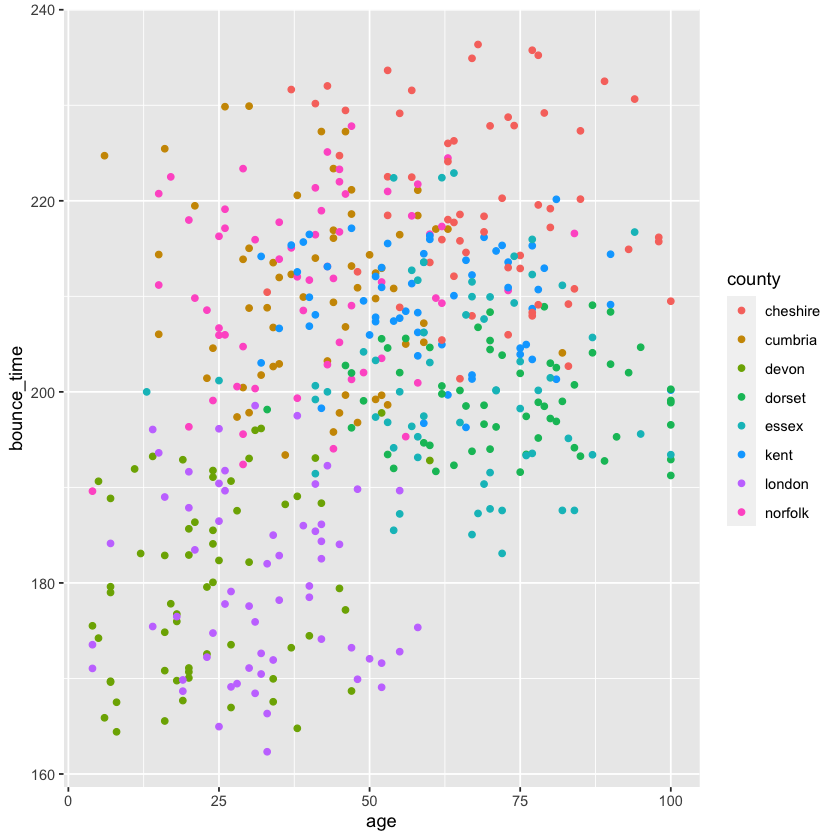

In [20]:
ggplot(data, aes(x = age, y = bounce_time)) + geom_point( aes(color = county))


You might be able to make out that the clusters don't cover the whole range or the dataset. Below I will plot boxes which encapsulate each cluster so we can see this much more clearly.

But first, I just want to graph the by cluster linear models so we can convince ourselves that there aren't, for example, loads of influential outliers.

`geom_smooth()` using formula 'y ~ x'



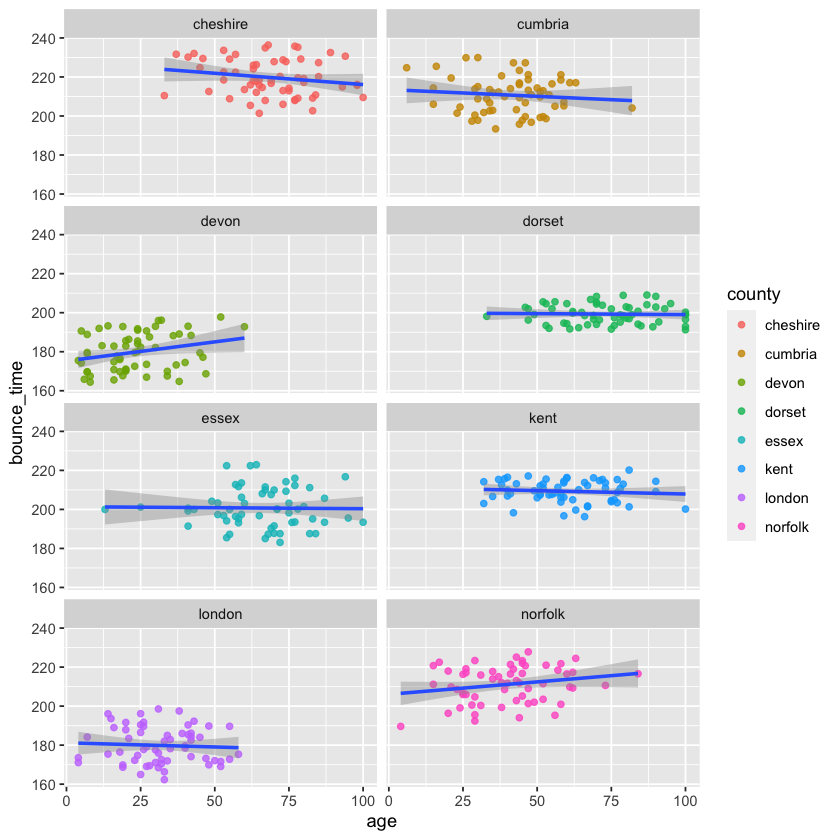

In [23]:
ggplot(data, aes(x = age, y = bounce_time)) + geom_point(aes(color = county), alpha = .8) +
geom_smooth(method = lm) + facet_wrap(~county, ncol = 2)

<a id='bad'></a>
## Why lme() is a Bad Idea

Now let's try to see what could have possibly gone so wrong. Below I have some more ugly R code which creates a dataframe specifying the maximum range of each cluster. The dataframe is organized in a particular way so that I can use `ggplot2`'s `geom_polygon` to print out some pretty graphs.

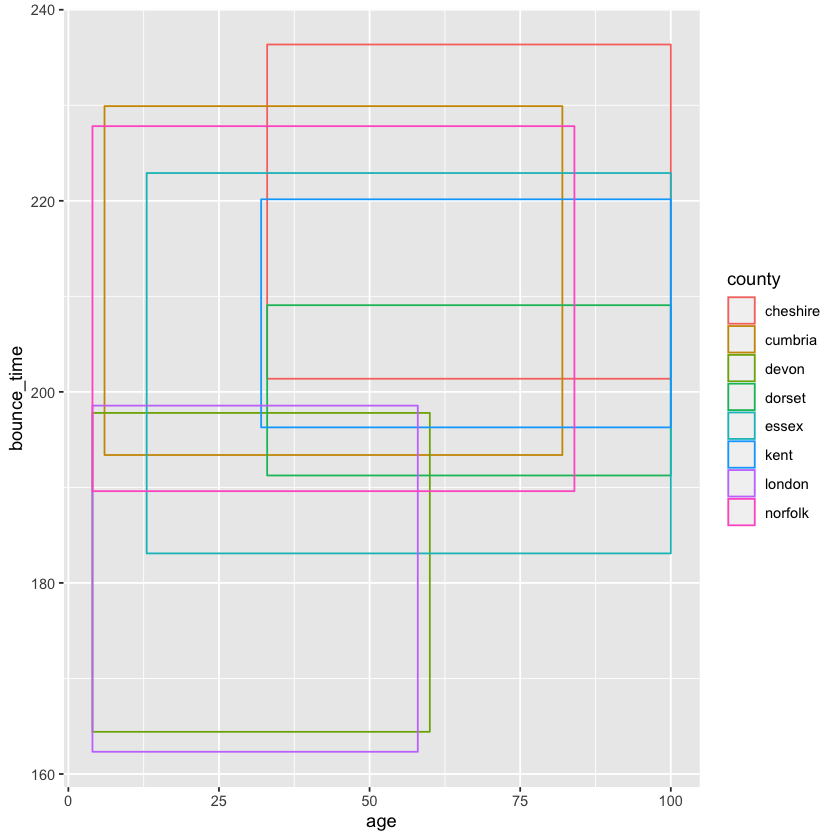

In [22]:
h <- function(l){
  x <- c()
  y <- c()
  i = 0
  while( i + 1 <= length(l)){
    x[4*i + c(1:4)] <- c(rep( c(min(data[which(data$county == l[i + 1]), "age"]),max(data[which(data$county == l[i + 1]), "age"])), each = 2))
    
    y[4*i + c(1:4)] <- c(min(data[which(data$county == l[i + 1]), "bounce_time"]),
                           rep(max(data[which(data$county == l[i + 1]), "bounce_time"]), 2),
                           min(data[which(data$county == l[i + 1]), "bounce_time"]))
    
    i = i + 1
  } 
  ret <- data.frame("x" = x, "y" = y)
  ret
}
counties <- levels(factor(data$county))
c <- data.frame("county" = rep(counties, each = 4))
vals <- data.frame("values" = rep(c(1:8), each = 4))
datageom <- cbind(h(counties), vals, c)

ggplot(datageom, aes(x = x, y = y)) + geom_polygon(aes(color = county, group = values),fill = NA) +
              xlab("age") + ylab("bounce_time")


So now it should be a little bit clearer that each cluster only occupies a small portion of the total range of the data. Below I split up this graph into two so you can make out that many of these boxes have very minimal intersection.

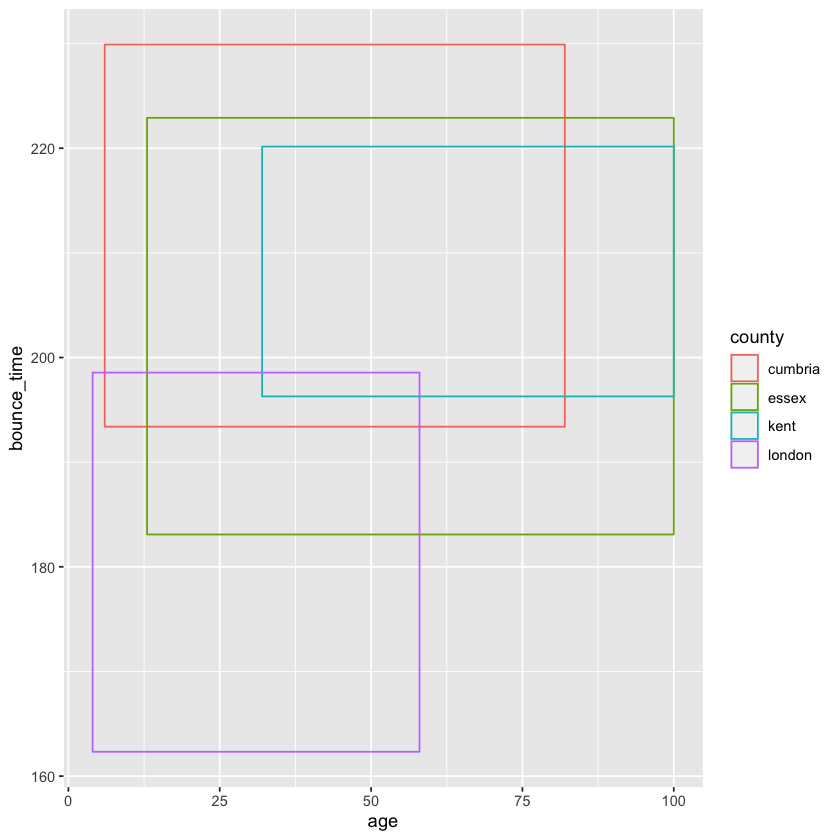

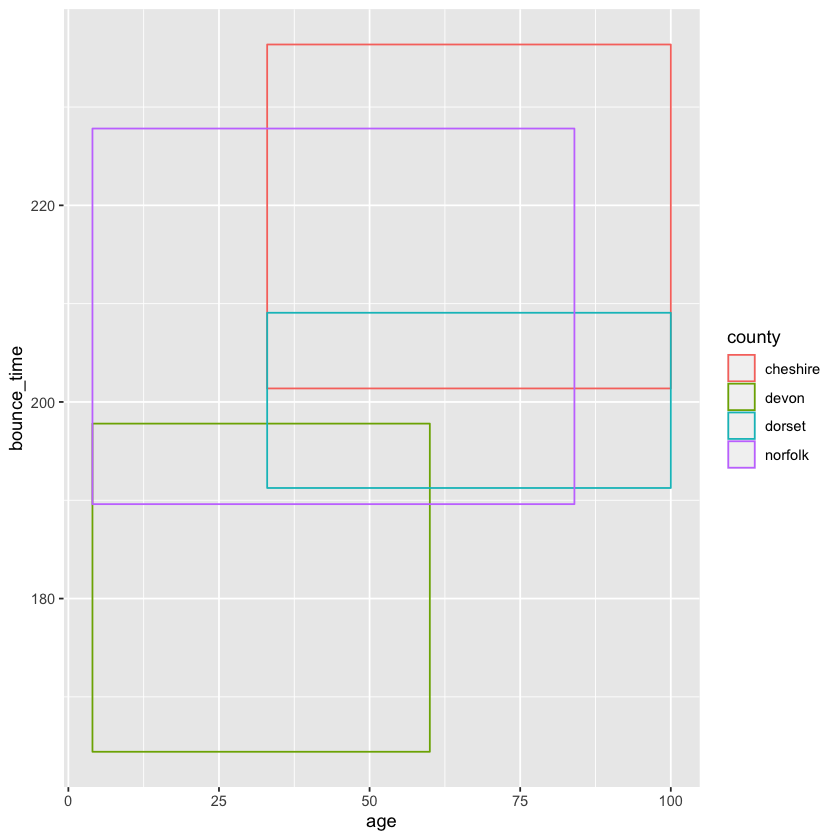

In [24]:
lst <- c("cumbria", "essex", "kent", "london")
ggplot(data = subset(datageom, county %in% lst), aes(x = x, y = y)) + geom_polygon(aes(color = county, group = values), fill = NA) +
  xlab("age") + ylab("bounce_time")
ggplot(data = subset(datageom, !county %in% lst), aes(x = x, y = y)) + geom_polygon(aes(color = county, group = values), fill = NA) +
  xlab("age") + ylab("bounce_time")


So now we have to answer the question: what went wrong? The behavior we see in this dataset is related to a phenomenon referred to as [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox). The fact that each cluster is largely distinct and only spans a small portion of the range isn't exactly what causes this but it does enable it.![Simpson's Paradox](https://upload.wikimedia.org/wikipedia/commons/f/fb/Simpsons_paradox_-_animation.gif)

Above is an illustrative gif of the phenomenon from the wikipedia article on Simpson's paradox. 

But we also shouldn't just ignore that the mixed effect model reduced rse (given all the parameters remained significant and all other assumptions are met). 

The reason I named this notebook When _Not_ to use Mixed Models is because we should not draw inferences from the predictions of the random effects. One of the aspects that makes linear mixed effects models is that it allows for inference unlike many machine learning regression techniques. So, if the aim was to create an explanatory analysis from this dataset, you should _not_ use an lmm. Linear mixed models were developed to analyze between group variation in controlled scientific studies where clustering of the sort above is not allowed to happen. That doesn't mean these models can't be used on data that didn't come from a carefully designed experiment but it just goes to show that statistical inferences should only be made once that data is very well understood.

<a id='fin'></a> 
## Conclusion

In this project I analysed a clustered dataset which turned out to have counterintuitive behavior similar to what is referred to as Simpson's paradox. Moreover, that dataset was conducive to enlightening data visualizations and concise analysis despite displaying strange behavior. Example like this highlight the rigourous analysis which must proceed statistical inference in the context of explanatory modeling.